### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?

Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

visual latency is in the order of 10ms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.markers as mmarkers
from matplotlib.markers import MarkerStyle
import matplotlib.animation as animation
import matplotlib.cm as cm
import copy

Import fish svg

In [2]:
fih_path, attributes = svg2paths('fih.svg')
fmarker = parse_path(attributes[0]['d'])
fmarker.vertices -= fmarker.vertices.mean(axis=0)
fmarker = fmarker.transformed(mpl.transforms.Affine2D().scale(1,-1))
# plt.plot(1,1,marker = fmarker, markersize = 100)

Initialization

In [3]:
def initialize(numfish, maxcoord, maxvelocity = 10):
    N = numfish #number of fish
    maxvelocity = maxvelocity #bodylength per seconds

    #init coordinations
    motcoords = [np.array([rng.uniform(-maxcoord,maxcoord),rng.uniform(-maxcoord,maxcoord)]) for i in np.arange(N)]

    # init orientations
    radmotangles = [np.array(rng.uniform(0, 2*np.pi)) for i in np.arange(N)]
    degmotangles = np.rad2deg(radmotangles)

    #initialize velocity magnitude array
    # motvelmag = np.zeros(N)
    
    #add initial velocities 
    motvelmag = rng.normal(1,0.5,numfish)

    #create a velocity (direction & magnitude) array
    motvel = [np.array((motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i]))) for i in np.arange(N)]
    return motcoords, radmotangles, motvelmag, motvel


Rule setting

In [4]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(mycoord - i) for i in coordarray]
    distances[myindex] = np.nan
    return distances

#define crossproduct
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    nearestdist = dist[np.nanargmin(dist)]
    return neighbor_index, nearestdist, dist

def findangletoneighbor(radmyorientation, mycoord, neighborcoord):
    myvector = (np.cos(radmyorientation),np.sin(radmyorientation))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    #calculate the dot product and the cross product
    dotproduct = np.dot(myvector, vector_from_me_to_you) 
    crossproduct = cross2d(myvector, vector_from_me_to_you)
    return dotproduct, crossproduct

#first find and index nearest neighbor
testcoord = np.array([0,0])
coords = [np.array([0,0]), np.array([-1,-1]), np.array([2,0]), np.array([0,3]), np.array([-4,3])]
findnearestneighbor(0, testcoord, coords)


(np.int64(1),
 np.float64(1.4142135623730951),
 [nan,
  np.float64(1.4142135623730951),
  np.float64(2.0),
  np.float64(3.0),
  np.float64(5.0)])

In [5]:
def finddistancetonearestwall(mycoord, maxcoord):
    
    xdistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[0]))
    ydistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[1]))

    if mycoord[0] < 0:
        xdistance = -1*xdistance
    else: xdistance = xdistance
    if mycoord[1] < 0:
        ydistance = -1*ydistance
    else: ydistance = ydistance
    return xdistance, ydistance


def findangletowall(radmyorientation, mycoord, maxcoord):
    myvector = np.array([np.cos(radmyorientation),np.sin(radmyorientation)])

    #nearest walls
    xwall, ywall = finddistancetonearestwall(mycoord, maxcoord)

    if xwall != 0:
        xwallvector = np.array([1,0]) if xwall < 0 else np.array([-1,0])
    else: xwallvector = np.array([0,0])
    if ywall != 0:
        ywallvector = np.array([0,1]) if ywall < 0 else np.array([0,-1])
    else: ywallvector = np.array([0,0])
    
    #calculate the dot product and the cross product
    xdotproduct = np.dot(myvector, xwallvector) 
    ydotproduct = np.dot(myvector, ywallvector) 
    xcrossproduct = cross2d(myvector,xwallvector)
    ycrossproduct = cross2d(myvector,ywallvector)
    return xdotproduct, ydotproduct, xcrossproduct, ycrossproduct

coord = (-2,2)
arena = 10

finddistancetonearestwall(coord,arena/2)

(np.float64(-3.0), np.float64(3.0))

Test

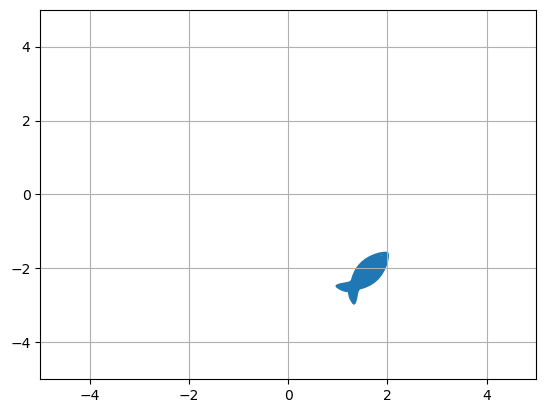

[array([ 1.50901895, -2.1982173 ])]
[44.69327425]
(np.float64(3.490981054707735), np.float64(-2.801782697469907))
(np.float64(-0.7108820379893684), np.float64(0.7033112597307697), np.float64(0.7033112597307697), np.float64(0.7108820379893684))


In [6]:
#test
poolsize = 10
N = 1
motcoords, radmotangles, motvelmag, motvel = initialize(N,poolsize/2)

xcoords, ycoords = zip(*motcoords)

degmotangles = np.rad2deg(radmotangles)

fig, ax = plt.subplots()
# scaling follows s = 160000/x^2 where x is the width of the coordinate
for i in np.arange(len(motcoords)):
    rotfmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
    ax.scatter(xcoords[i],ycoords[i], marker = rotfmarker, s = 160000/poolsize**2)

ax.set_xlim(-poolsize/2,poolsize/2)
ax.set_ylim(-poolsize/2,poolsize/2)
ax.grid()
plt.show()

print(motcoords)
print(degmotangles)

for i in np.arange(N):
    # print(findangletoneighbor(radmotangles[0], motcoords[0], motcoords[i]))
    print(finddistancetonearestwall(motcoords[0], poolsize/2))
    print(findangletowall(radmotangles[0],motcoords[0],poolsize/2))


- Radius of 1 body length = R 
- Speed: (front-back over side-side): This acceleration response was dependent on the fish’s current speed (multiply velocity by a factor)
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor?
- Maybe some weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back
- Turn: (relative angle over distance)
- Turn towards neighbor’s position, unless within radius R
- Include wall repulsion and boundary condition


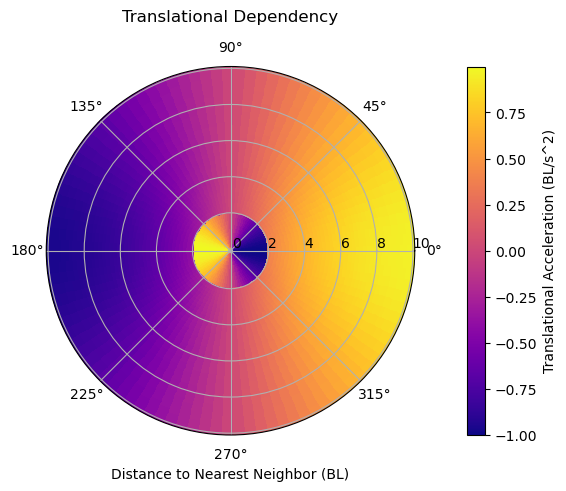

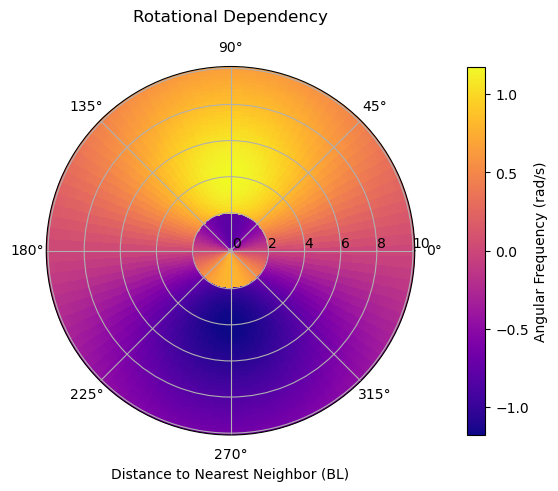

In [7]:
#plot the translational and angular acceleration functions:
r_values = np.linspace(0, 10, 50)  # Radial distances
theta_values = np.linspace(0, 2 * np.pi, 100) # Angles in radians
R, THETA = np.meshgrid(r_values, theta_values)

# Example 'z'data (e.g., a function of r and theta)
Zfar = np.cos(THETA) * np.tanh(R/5)
Zclose = -np.cos(THETA)

Zclose_masked = np.where(R <= 2, Zclose, np.nan)

#consistent Acceleration values for heatmap
Zmin = np.nanmin([Zfar.min(), Zclose.min()])
Zmax = np.nanmax([Zfar.max(), Zclose.max()])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, Zfar, cmap='plasma', vmin=Zmin, vmax=Zmax) # Choose a colormap
heatmapclose = ax.pcolormesh(THETA, R, Zclose_masked, cmap='plasma',vmin=Zmin, vmax=Zmax) # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='Translational Acceleration (BL/s^2)')
ax.set_title('Translational Dependency', y= 1.1)
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")

plt.show()

#Angular acceleration heatmap * np.tanh(R/5)
AAfar = 0.8*np.sin(THETA)*R*np.exp(-R/4)
AAclose = -0.8*np.sin(THETA)

# AAclose_masked = np.where(R <= 2, AAclose, np.nan)
AAclose_masked = np.where(R <= 2, AAclose, np.nan)

#consistent angular frequency values for heatmap
AAmin = np.nanmin([AAfar.min(), AAclose.min()])
AAmax = np.nanmax([AAfar.max(), AAclose.max()])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},constrained_layout=True)
heatmapfar = ax.pcolormesh(THETA, R, AAfar, cmap='plasma',vmin=AAmin, vmax=AAmax) # Choose a colormap
heatmapclose = ax.pcolormesh(THETA, R, AAclose_masked, cmap='plasma',vmin=AAmin, vmax=AAmax) # Choose a colormap

fig.colorbar(heatmapfar, ax=ax, label='Angular Frequency (rad/s)')
ax.set_title('Rotational Dependency', y= 1.1)
ax.set_rlabel_position(0) # Adjust position of radial labels
ax.set_xlabel("Distance to Nearest Neighbor (BL)")

plt.show()



In [120]:
#run this for all fish in one timestep
#we can also change the fish to only respond to a certain angle of neighbor, like -pi/3 to pi/3 rad
#error about 0.25 maybe, can change

def updatefish(positions,radorientations,speeds,velocity, arenarange = 100, time = 0, timestep = 0.1, maxa = 1.0, maxdw = 0.8, erroracc = 0.05, errordw = 0.02, maxspd = 10):
    copypositions = positions.copy()
    time += timestep
    t = timestep
    N = len(positions)
    maxspeed = maxspd
    maxcoord = arenarange/2
    for i in np.arange(N):
        #first find the nearest neighbor
        neighindex, neighdist, dist = findnearestneighbor(i, copypositions[i], copypositions)
        #find its dotproduct
        dotproduct, crossproduct = findangletoneighbor(radorientations[i],copypositions[i],copypositions[neighindex]) #simply cos(theta) and sin(theta)

        #error in acceleration
        Aerror = rng.uniform(-erroracc,erroracc)
        Dwerror = rng.uniform(-errordw,errordw)

        #calculate the accelerations based on the dotproduct and the distance to the neighbor
        motaccpositive = maxa*dotproduct*np.tanh(neighdist/5) + Aerror
        motaccnegative = maxa*dotproduct + Aerror #assume no huge distance dependence
        dwfar = maxdw*crossproduct*neighdist*np.exp(-neighdist/4) + Dwerror
        dwnear = maxdw*crossproduct + Dwerror
        
        #Speed rule 1, attractve over R (2 body lengths) 
        if neighdist > 2:
            #update velocity magnitude based on where the other fish is. If in front, accelerate, if behind, deccelerate
            if np.abs(speeds[i] + motaccpositive*t) <= maxspeed:
                speeds[i] = max(0, speeds[i] + motaccpositive*t)
            else:
                speeds[i] = max(0, speeds[i] + Aerror*t)
        #speed rule 2, repulsive under R
        elif neighdist < 2:
            #if behind, accelerate forward. if ahead, decelerate
            if np.abs(speeds[i] - motaccnegative*t) <= maxspeed:
                speeds[i] = max(0,speeds[i] - motaccnegative*t)
            else:
                speeds[i] = speeds[i] = max(0, speeds[i] + Aerror*t)

        #orientation rule 1, turn towards nearest neighbor
        if neighdist > 2: #radpersecond
            radorientations[i] = radorientations[i] + dwfar*t
        elif neighdist < 2: #radpersecond
            radorientations[i] = radorientations[i] -  dwnear*t

        #add repulsive force towards wall
        xwalldist, ywalldist = finddistancetonearestwall(copypositions[i], maxcoord)
        xwalldot, ywalldot, xwallcross, ywallcross = findangletowall(radorientations[i], copypositions[i], maxcoord)
        
        #make sure direction is correct
        xsign = np.sign(xwallcross)
        ysign = np.sign(ywallcross)
        
        #angular frequency for wall 
        dwwallx = maxdw*np.abs(xwalldot)*xsign + Dwerror
        dwwally = maxdw*np.abs(ywalldot)*ysign + Dwerror

        if np.abs(xwalldist) < 2 and xwalldot < 0:
            radorientations[i] += dwwallx * t

        if np.abs(ywalldist) < 2 and ywalldot < 0:   
            radorientations[i] += dwwally * t

        if xwalldot < 0 and ywalldot < 0 and np.sqrt(xwalldist**2+ywalldist**2) < 4:
            radorientations[i] += rng.choice([-3*np.pi/4,3*np.pi/4])

        #wall effect on acceleration. decelerate if dot product is negative, accelerate if positive
        awallx = maxa*xwalldot + Dwerror
        awally = maxa*ywalldot + Dwerror

        if np.abs(xwalldist) < 2:
            speeds[i] += awallx * t

        if np.abs(ywalldist) < 2:   
            speeds[i] += awally * t
        
        #update velocity
        velocity[i] = (speeds[i]*np.cos(radorientations[i]),speeds[i]*np.sin(radorientations[i]))

        #check position so that it is in bounds
        checknewposition = positions[i] + np.array(velocity[i])*t

        #if out of bounds, move fish to 1 BL from border and decelerate to 0, update velocity
        if np.abs(checknewposition[0]) > maxcoord or np.abs(checknewposition[1]) > maxcoord:
            if checknewposition[0] > maxcoord:
                positions[i][0] = maxcoord - 1
            if checknewposition[0] < -maxcoord:
                positions[i][0] = -maxcoord + 1
            if checknewposition[1] > maxcoord:
                positions[i][1] = maxcoord - 1
            if checknewposition[1] < -maxcoord:
                positions[i][1] = -maxcoord + 1
            
            speeds[i] = 0
            velocity[i] = (0,0)
        else: positions[i] = positions[i] + np.array(velocity[i])*t # update position according to x = x+vt for all fish
        
    return positions, radorientations, speeds, velocity, time

Plot and analysis

In [104]:
#plotting function

def plot(coords, radorientations, viewrange = (-50,50), title = '', fishmarker = fmarker):
    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    colors = cm.rainbow(np.linspace(0, 1, N))
    
    fig, ax = plt.subplots()
    # scaling follows s = 160000/x^2 where x is the width of the coordinate

    for i in np.arange(N):
        rotmarker = fishmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 160000/figurelength**2, color = colors[i])

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()
    plt.show()


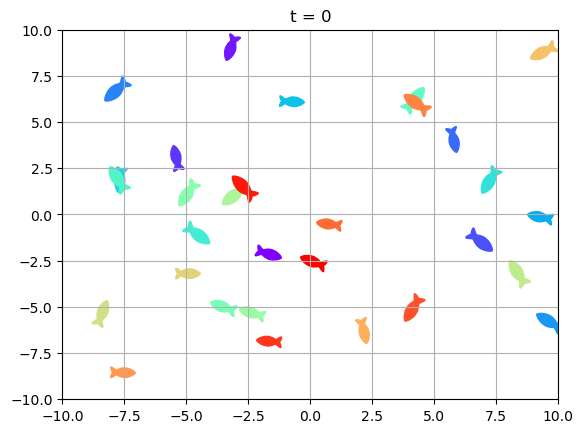

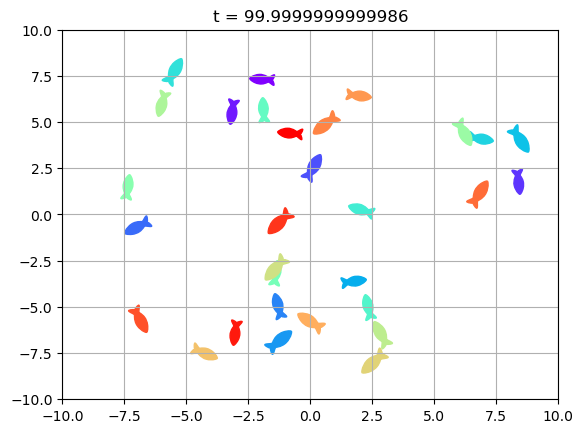

In [129]:
numiterations = 1000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 30
inittime = 0
positionarray = []
speedarray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)
    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')

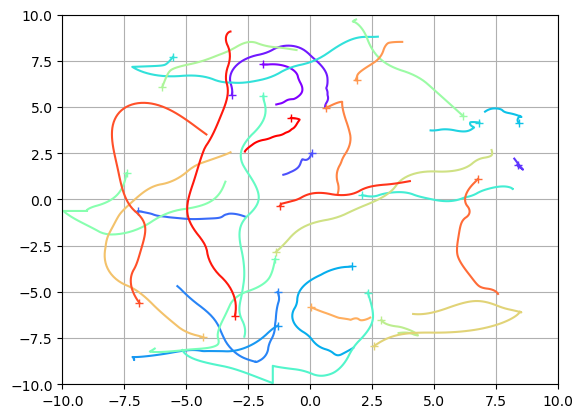

In [130]:
#trajectory plot
fig, ax = plt.subplots()

plotmaxcoord = poolrange/2
trajlength = 100

colors = cm.rainbow(np.linspace(0, 1, numfish))

for n in np.arange(numfish):
    coordinates = []
    for i in np.arange(numiterations):
        coordinates.append(positionarray[i][n])
    fishcoordsx, fishcoordsy = zip(*coordinates)

    recent_x = fishcoordsx[-trajlength:]
    recent_y = fishcoordsy[-trajlength:] 

    ax.plot(recent_x, recent_y, color=colors[n])
    ax.plot(recent_x[-1], recent_y[-1], marker='+', color=colors[n])

ax.set_xlim(-plotmaxcoord,plotmaxcoord)
ax.set_ylim(-plotmaxcoord,plotmaxcoord)
ax.grid()
plt.show()


In [114]:
#final velocity plot function
def plotvel(coords, radorientations, speeds, viewrange = (-50,50), title = ''):
    markerstyle = MarkerStyle(marker= '_')

    figurelength = viewrange[1]-viewrange[0]
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    
    fig, ax = plt.subplots()

    # scaling of the length is proportional to the velocity
    for i in np.arange(N):
        rotmarker = markerstyle.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        scale = speeds[i]
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 500*scale)

    #plot view range
    ax.set_xlim(viewrange[0],viewrange[1])
    ax.set_ylim(viewrange[0],viewrange[1])

    ax.set_title(title)
    ax.grid()

    plt.show()

/opt/anaconda3/lib/python3.13/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


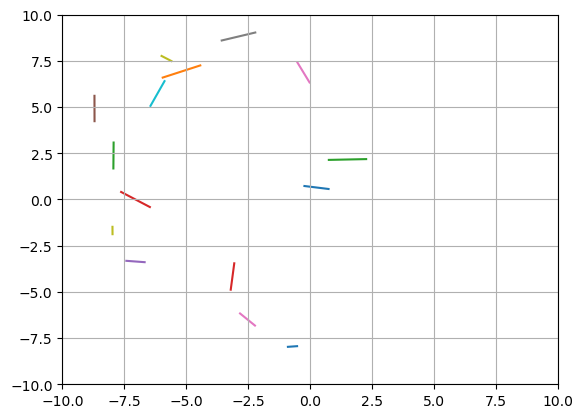

In [123]:
#final velocity plot:
plotvel(pos, motorientations, motspeeds, viewrange = (-plotmaxcoord,plotmaxcoord))

np.float64(0.5769507099888773)

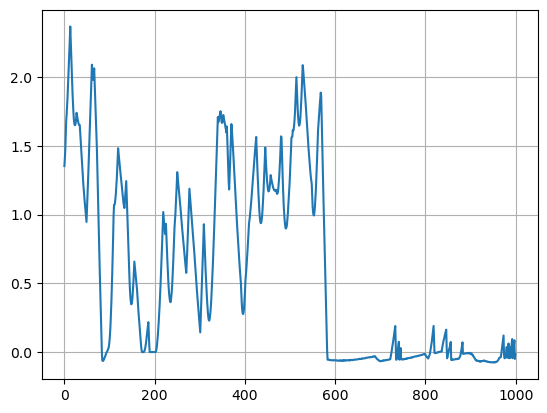

In [126]:
#plot changes in speed:
speedarray
speedonefish = [array[1] for array in speedarray]
plt.plot(np.arange(len(speedonefish)),speedonefish)
plt.grid()
np.mean(speedonefish)

Analysis

For different error values 
Polarization for different error
Cohesion for different error
Milling for different error
average center of mass speed 
average center of mass position



In [15]:
#center of mass

def findCM(positionarray):
    N = len(positionarray)
    sum = np.sum(positionarray, axis = 0)
    centerofmass = sum/N
    return centerofmass

def findVCM(velocityarray):
    N = len(velocityarray)
    sum = np.sum(velocityarray, axis = 0)
    Vcm = sum/N
    return Vcm

def findP(radorientations):
    N = len(radorientations)
    #normalize the velocities => basically [cos(angle),sin(angle)]
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    #add them up
    NormVsum = np.sum(normvel, axis = 0)
    #take the magnitude of the sum
    mag = np.linalg.norm(NormVsum)
    #divide by N
    P = mag/N
    return P

#also known as dispersion
def findCohesion(positionarray):
    N = len(positionarray)
    cm = findCM(positionarray)
    distfromcm = [np.linalg.norm(coords-cm) for coords in positionarray] 
    distsquared = np.square(distfromcm)
    distsqsum = np.sum(distsquared, axis = 0)
    cohesion = np.sqrt(distsqsum/N)
    return cohesion

def findMilling(positionarray, radorientations):
    N = len(positionarray)
    normvel = [np.array([np.cos(i),np.sin(i)]) for i in radorientations]
    normpos = [position/np.linalg.norm(position) for position in positionarray]
    crossp = [cross2d(normpos[i], normvel[i]) for i in np.arange(N)]
    sumofcrossp = np.sum(crossp, axis = 0)
    milling = np.abs(sumofcrossp)/N
    return milling



Perform analysis for numfish = 5, 10, 50

for different error and maybe different maxa 

we need to check if they result in an equilibriated state
let's start with n = 5

Keep numiterations = 1000
poolrange = 20
initcoordmax = 10 

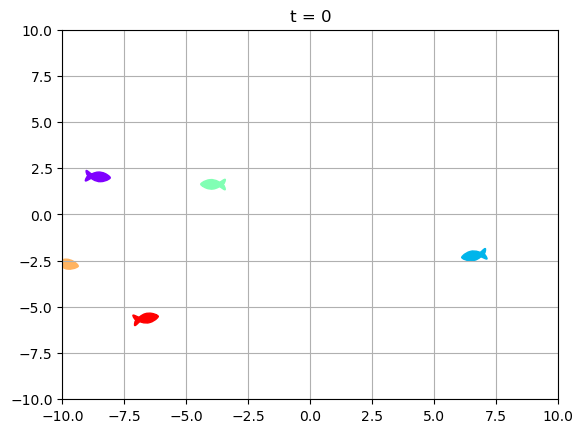

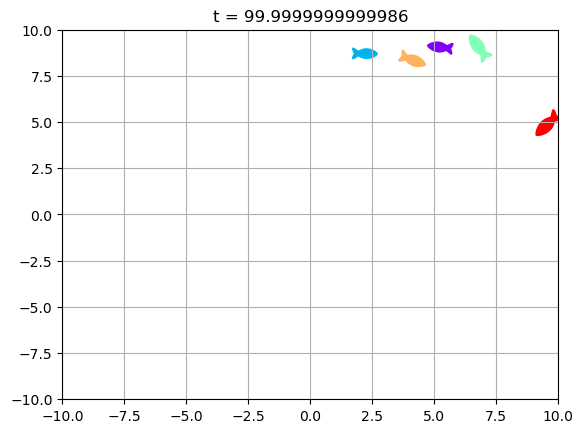

In [16]:
# N = 5

numiterations = 1000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 5
inittime = 0

#data arrays
positionarray = []
speedarray = []
cmpositionarray = []
cmvelocityarray = []
Parray = []
Carray = []
Marray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
#initial plot
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)

    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

    cmposition = findCM(pos)
    cmpositionarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    cmvelocityarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    Parray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    Carray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    Marray.append(copy.deepcopy(Milling))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')

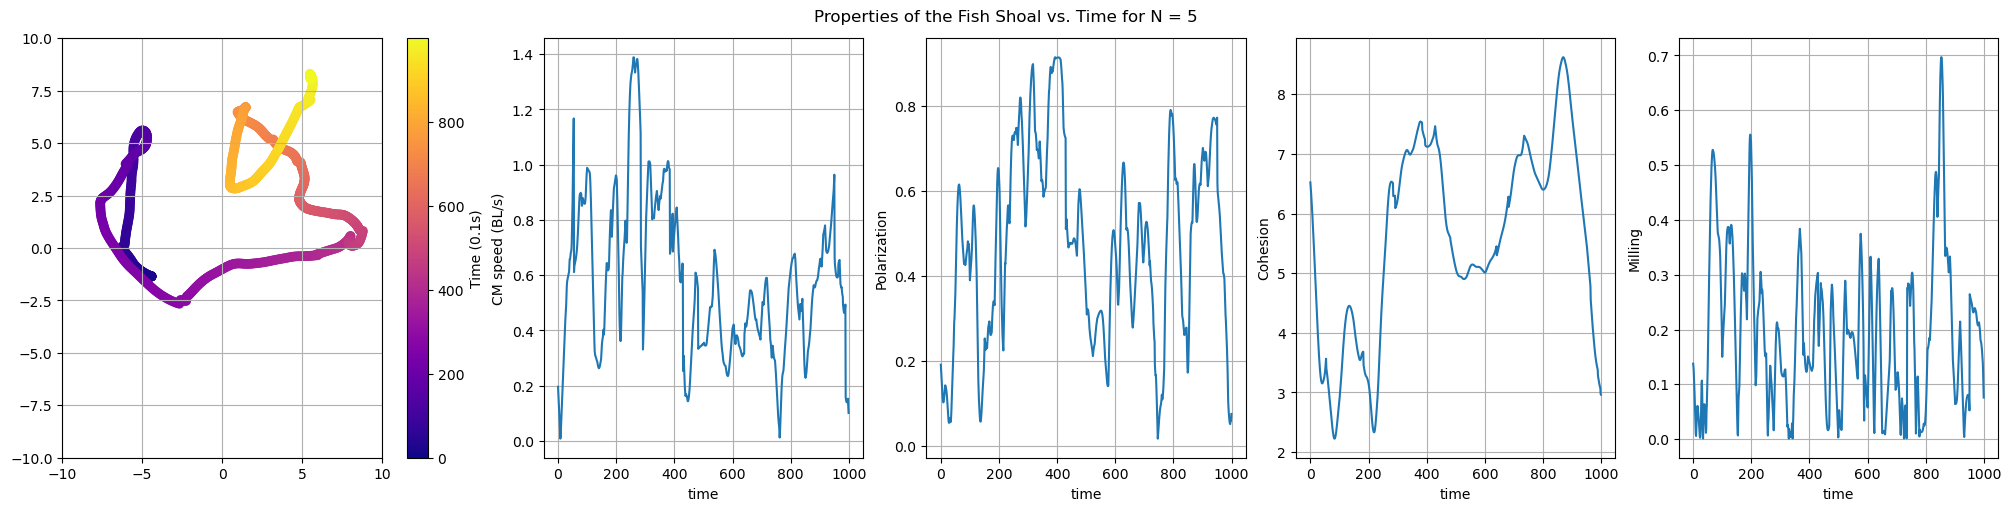

In [17]:
# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for N = 5')

time = np.arange(numiterations)

#plot center of mass over time
cmxcoords, cmycoords = zip(*cmpositionarray)
c_values = np.arange(len(cmxcoords))

sc = axs[0].scatter(cmxcoords, cmycoords, c = c_values, cmap = 'plasma')
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label("Time (0.1s)")

#plot center of mass speed over time
cmspeed = [np.linalg.norm(velocity) for velocity in cmvelocityarray]

axs[1].plot(time, cmspeed)
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('CM speed (BL/s)')


# plot polarization over time Parray = []
axs[2].plot(time, Parray)
axs[2].grid()
axs[2].set_xlabel('time')
axs[2].set_ylabel('Polarization')


# Carray = []
axs[3].plot(time, Carray)
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Cohesion')

# Marray = []
axs[4].plot(time, Marray)
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Milling')

plt.show()

Conclusion, we don't see equilibrium over time

In [18]:
#Now run it many times and find the average properties at t = 1000
numsim = 10

totalcmarray = []
totalcmVarray = []
totalParray = []
totalCarray = []
totalMarray = []

for i in np.arange(numsim):
    numiterations = 10
    poolrange = 20 #poolrange/2 is the length of each side
    initcoordmax = 10 #essentially initial density
    numfish = 5
    inittime = 0

    pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
    
    #run the simulation numiteration times
    for i in np.arange(numiterations):
        pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, )

    #calculate the final properties
    cmposition = findCM(pos)
    totalcmarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    totalcmVarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    totalParray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    totalCarray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    totalMarray.append(copy.deepcopy(Milling))

0.2896828752781334
7.2005932125070995
0.20781680467624133


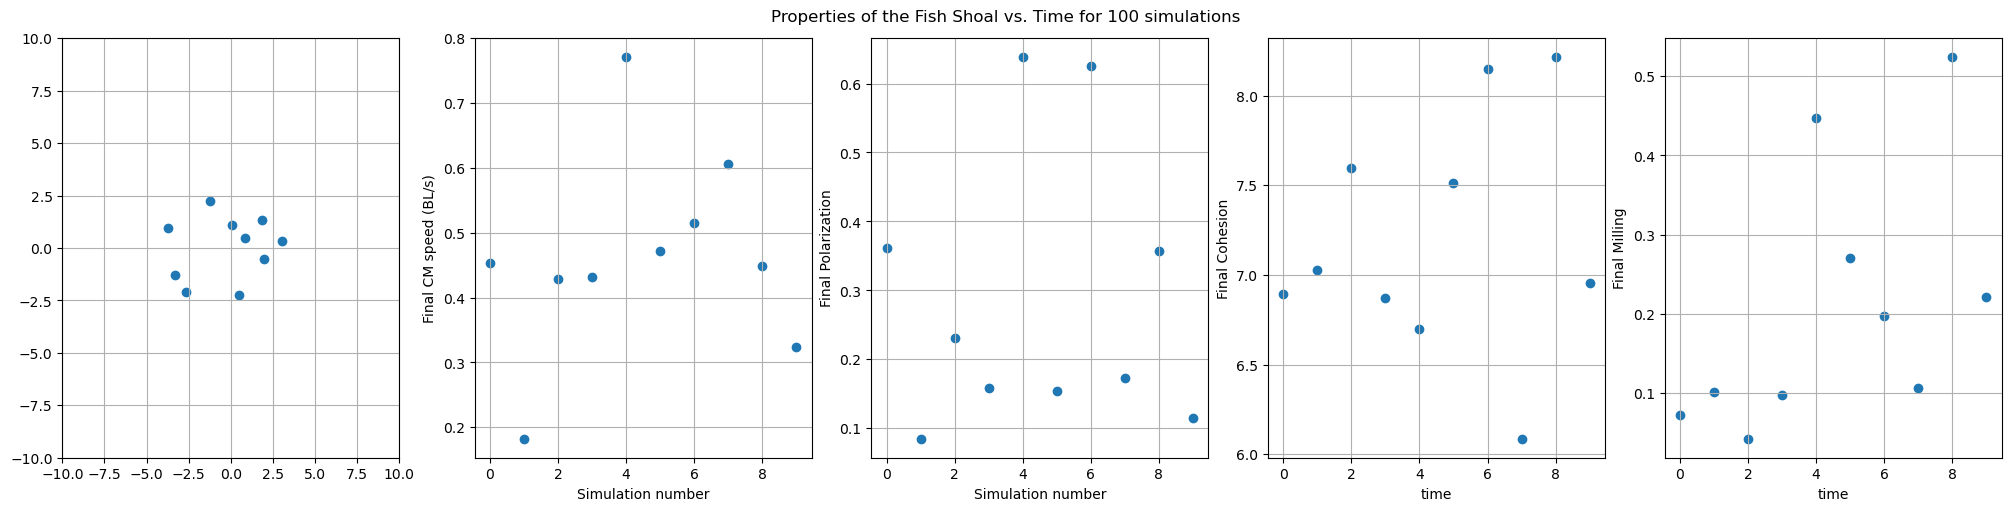

In [19]:
#plot each for N = 5

# numiterations = 1000
# poolrange = 40 #poolrange/2 is the length of each side
# initcoordmax = 20 #essentially initial density
# numfish = 5
# inittime = 0

# totalcmarray = []
# totalcmVarray = []
# totalParray = []
# totalCarray = []
# totalMarray = []

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for 100 simulations')

Nsim = np.arange(numsim)

#plot center of masses
cmxcoords, cmycoords = zip(*totalcmarray)

axs[0].scatter(cmxcoords, cmycoords)
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()

#plot center of mass speeds
cmspeed = [np.linalg.norm(velocity) for velocity in totalcmVarray]

axs[1].scatter(Nsim, cmspeed)
axs[1].grid()
axs[1].set_xlabel('Simulation number')
axs[1].set_ylabel('Final CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].scatter(Nsim, totalParray)
print(np.mean(totalParray))
axs[2].grid()
axs[2].set_xlabel('Simulation number')
axs[2].set_ylabel('Final Polarization')


# Carray = []
axs[3].scatter(Nsim, totalCarray)
print(np.mean(totalCarray))
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Final Cohesion')

# Marray = []
axs[4].scatter(Nsim, totalMarray)
print(np.mean(totalMarray))
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Final Milling')

plt.show()

Polarization around 0.5, Cohesion around 12, Milling around 0.35

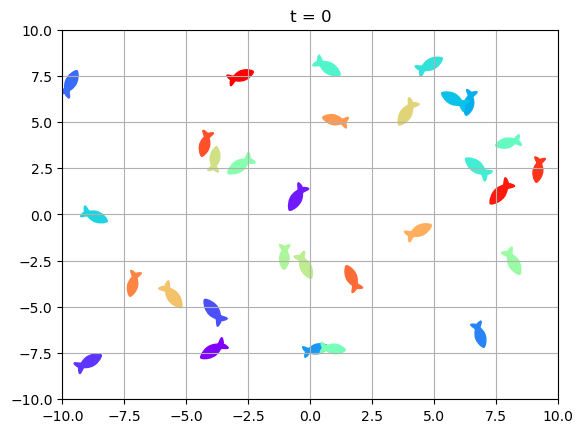

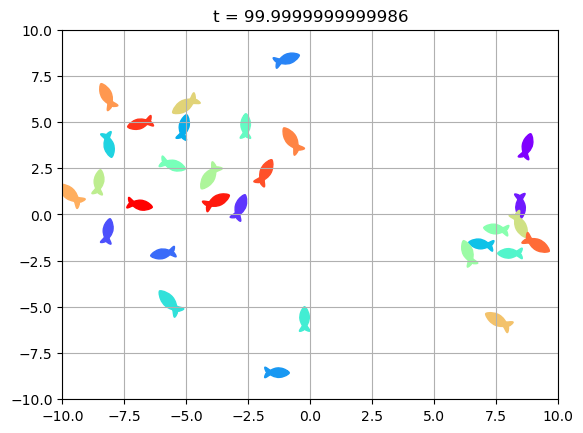

In [139]:
# N = 30
numiterations = 1000
poolrange = 20 #poolrange/2 is the length of each side
initcoordmax = 10 #essentially initial density
numfish = 30
inittime = 0

#data arrays
positionarray = []
speedarray = []
cmpositionarray = []
cmvelocityarray = []
Parray = []
Carray = []
Marray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
#initial plot
plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = 't = 0')

#run the function numiteration times and keep track of positions
for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange)

    speedarray.append(copy.deepcopy(motspeeds))
    positionarray.append(copy.deepcopy(pos))

    cmposition = findCM(pos)
    cmpositionarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    cmvelocityarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    Parray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    Carray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    Marray.append(copy.deepcopy(Milling))

plot(pos, motorientations, viewrange = (-poolrange/2,poolrange/2), title = f't = {inittime}')

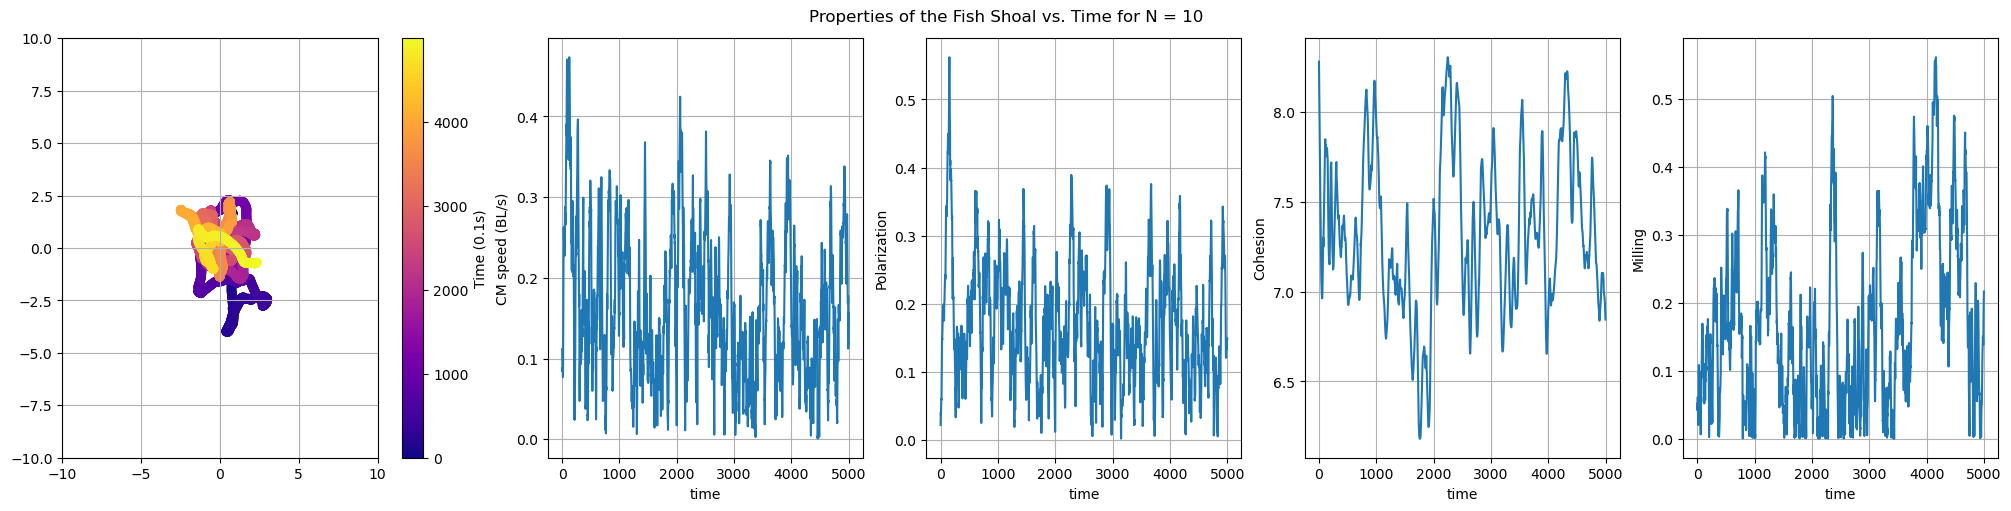

In [135]:
#N = 30 

# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for N = 10')

time = np.arange(numiterations)

#plot center of mass over time
cmxcoords, cmycoords = zip(*cmpositionarray)
c_values = np.arange(len(cmxcoords))

sc = axs[0].scatter(cmxcoords, cmycoords, c = c_values, cmap = 'plasma')
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()
cbar = plt.colorbar(sc, ax=axs[0])
cbar.set_label("Time (0.1s)")

#plot center of mass speed over time
cmspeed = [np.linalg.norm(velocity) for velocity in cmvelocityarray]

axs[1].plot(time, cmspeed)
axs[1].grid()
axs[1].set_xlabel('time')
axs[1].set_ylabel('CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].plot(time, Parray)
axs[2].grid()
axs[2].set_xlabel('time')
axs[2].set_ylabel('Polarization')

# Carray = []
axs[3].plot(time, Carray)
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Cohesion')

# Marray = []
axs[4].plot(time, Marray)
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Milling')

plt.show()

In [136]:
#Now run it many times and find the average properties at t = 5000 start counting at 500
#N = 50
numsim = 10

totalcmarray = []
totalcmVarray = []
totalParray = []
totalCarray = []
totalMarray = []

for i in np.arange(numsim):
    numiterations = 2000
    poolrange = 20 #poolrange/2 is the length of each side
    initcoordmax = 10 #essentially initial density
    numfish = 30
    inittime = 0

    pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
    
    #run the simulation numiteration times
    for i in np.arange(numiterations):
        pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, )

    #calculate the final properties
    cmposition = findCM(pos)
    totalcmarray.append(copy.deepcopy(cmposition))

    cmvelocity = findVCM(motvelocity)
    totalcmVarray.append(copy.deepcopy(cmvelocity))

    Polarization = findP(motorientations)
    totalParray.append(copy.deepcopy(Polarization))

    Cohesion = findCohesion(pos)
    totalCarray.append(copy.deepcopy(Cohesion))

    Milling = findMilling(pos, motorientations)
    totalMarray.append(copy.deepcopy(Milling))

Mean Polarization: 0.1794817671226728
Mean Cohesion: 7.361554637014649
Mean Milling: 0.20701975618453844


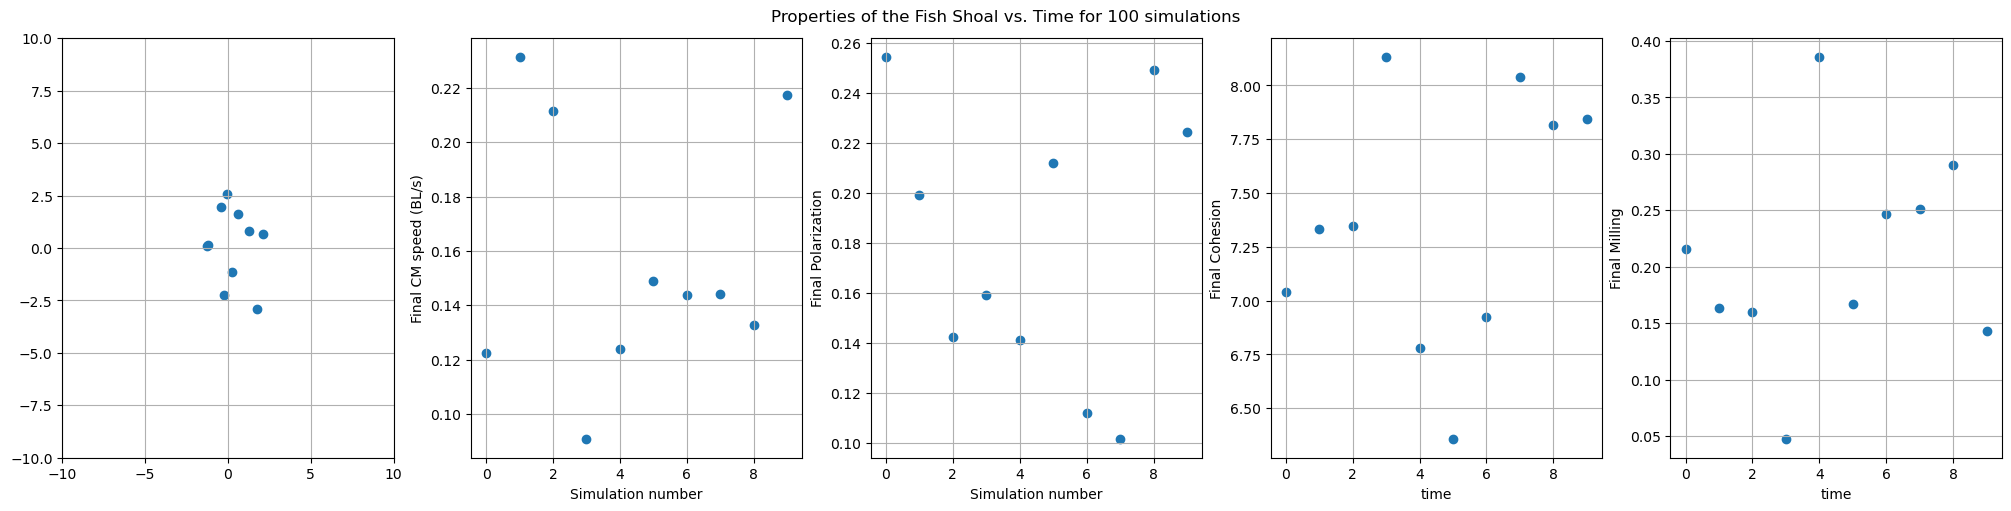

In [138]:
#plot each for N = 30

# numiterations = 1000
# poolrange = 20 #poolrange/2 is the length of each side
# initcoordmax = 10 #essentially initial density
# numfish = 5
# inittime = 0

# totalcmarray = []
# totalcmVarray = []
# totalParray = []
# totalCarray = []
# totalMarray = []

fig, axs = plt.subplots(1,5,constrained_layout = True, figsize = (20,5))
fig.suptitle('Properties of the Fish Shoal vs. Time for 100 simulations')

Nsim = np.arange(len(totalcmarray[-1500:]))

#plot center of masses
cmxcoords, cmycoords = zip(*totalcmarray)

axs[0].scatter(cmxcoords, cmycoords)
axs[0].set_xlim(-poolrange/2,poolrange/2)
axs[0].set_ylim(-poolrange/2,poolrange/2)
axs[0].grid()

#plot center of mass speeds
cmspeed = [np.linalg.norm(velocity) for velocity in totalcmVarray]

axs[1].scatter(Nsim, cmspeed[-1500:])
axs[1].grid()
axs[1].set_xlabel('Simulation number')
axs[1].set_ylabel('Final CM speed (BL/s)')

# plot polarization over time Parray = []
axs[2].scatter(Nsim, totalParray[-1500:])
print(f'Mean Polarization: {np.mean(totalParray)}')
axs[2].grid()
axs[2].set_xlabel('Simulation number')
axs[2].set_ylabel('Final Polarization')


# Carray = []
axs[3].scatter(Nsim, totalCarray[-1500:])
print(f'Mean Cohesion: {np.mean(totalCarray)}')
axs[3].grid()
axs[3].set_xlabel('time')
axs[3].set_ylabel('Final Cohesion')

# Marray = []
axs[4].scatter(Nsim, totalMarray[-1500:])
print(f'Mean Milling: {np.mean(totalMarray)}')
axs[4].grid()
axs[4].set_xlabel('time')
axs[4].set_ylabel('Final Milling')

plt.show()

We notice that the average polarization and milling both decrease with N, while cohesion increases. 

Find relation with error. For each N = 5,10,30, run the experiment 100 times with acceleration error = 0, 0.1, 0.2, 0.3, 0.4, 0.5 and check mean polarization, cohesion, milling to try to observe phase transition.

In [177]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
Aerrors = np.linspace(0,0.5,10)

meanParrays = [[],[],[]]
meanCarrays = [[],[],[]]
meanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for A in Aerrors: 
        #Run it many times and find the average properties at t = 1000
        numsim = 10
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, erroracc = A)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        meanParrays[index].append(meanP)
        meanCarrays[index].append(meanC)
        meanMarrays[index].append(meanM)

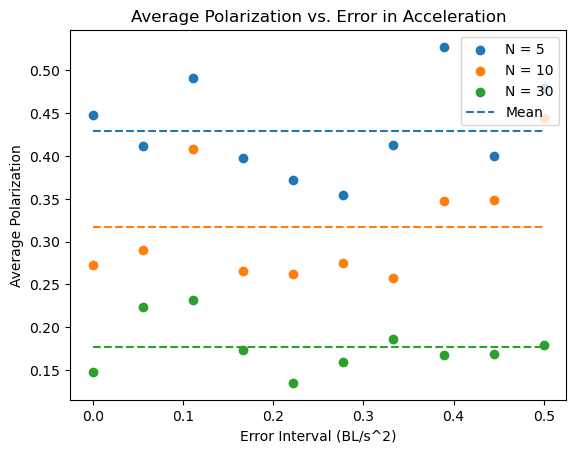

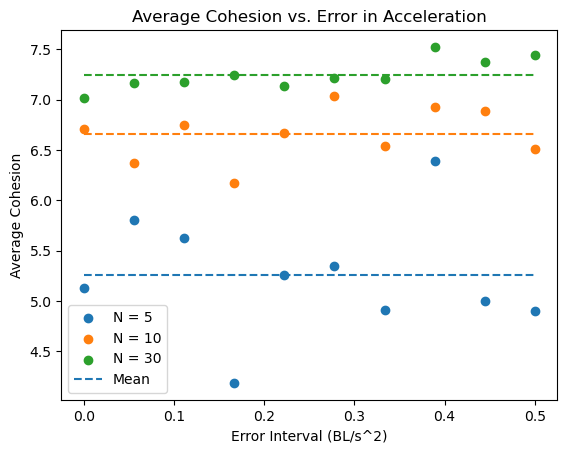

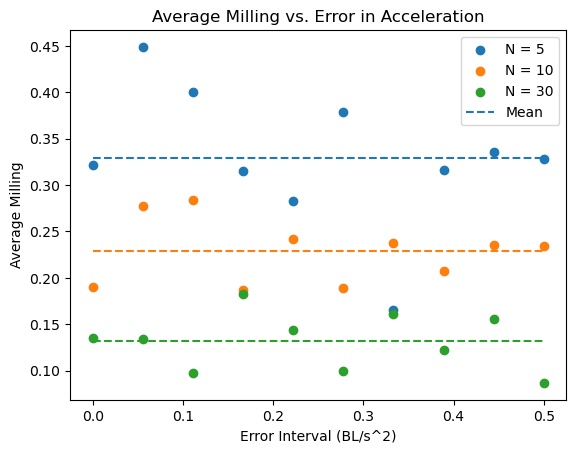

In [189]:
#polarization plot
plt.scatter(Aerrors,meanParrays[0], label = 'N = 5')
plt.scatter(Aerrors,meanParrays[1], label = 'N = 10')
plt.scatter(Aerrors,meanParrays[2], label = 'N = 30')
plt.hlines(y = [np.mean(meanParrays[0]),np.mean(meanParrays[1]),np.mean(meanParrays[2])], xmin = 0, xmax = 0.5,  linestyles='--', label='Mean', colors = ['C0', 'C1', 'C2'])
plt.title('Average Polarization vs. Error in Acceleration')
plt.xlabel('Error Interval (BL/s^2)')
plt.ylabel('Average Polarization')
plt.legend(loc = 'upper right')
plt.show()

#cohesion plot
plt.scatter(Aerrors,meanCarrays[0], label = 'N = 5')
plt.scatter(Aerrors,meanCarrays[1], label = 'N = 10')
plt.scatter(Aerrors,meanCarrays[2], label = 'N = 30')
plt.hlines(y = [np.mean(meanCarrays[0]),np.mean(meanCarrays[1]),np.mean(meanCarrays[2])], xmin = 0, xmax = 0.5,  linestyles='--', label='Mean', colors = ['C0', 'C1', 'C2'])
plt.title('Average Cohesion vs. Error in Acceleration')
plt.xlabel('Error Interval (BL/s^2)')
plt.ylabel('Average Cohesion')
plt.legend()
plt.show()

#Milling plot
plt.scatter(Aerrors,meanMarrays[0], label = 'N = 5')
plt.scatter(Aerrors,meanMarrays[1], label = 'N = 10')
plt.scatter(Aerrors,meanMarrays[2], label = 'N = 30')
plt.hlines(y = [np.mean(meanMarrays[0]),np.mean(meanMarrays[1]),np.mean(meanMarrays[2])], xmin = 0, xmax = 0.5,  linestyles='--', label='Mean', colors = ['C0', 'C1', 'C2'])
plt.title('Average Milling vs. Error in Acceleration')
plt.xlabel('Error Interval (BL/s^2)')
plt.ylabel('Average Milling')
plt.legend()
plt.show()

Conclusion: no real dependency with error in acceleration. However, there is a dependency between the size (or density) and the average P,C,and M, that is consistent across all error intervals. 

Find relation with error. For each N = 5,10,50, run the experiment 100 times with angular frequency error = 0.1, 0.1, 0.2, 0.3, 0.4, 0.5 and check mean polarization, cohesion, milling to try to observe phase transition.

In [ ]:
#Do it for N = 5,10,30 to see if anything happens
N = [5,10,30]
Werrors = np.linspace(0,0.5,10)

meanParrays = [[],[],[]]
meanCarrays = [[],[],[]]
meanMarrays = [[],[],[]]

for index in np.arange(len(N)):
    for A in Werrors: 
        #Run it many times and find the average properties at t = 1000
        numsim = 10
        totalParray = []
        totalCarray = []
        totalMarray = []

        for n in np.arange(numsim):
            numiterations = 1000
            poolrange = 20 #poolrange/2 is the length of each side
            initcoordmax = 10 #essentially initial density
            numfish = N[index]
            inittime = 0

            pos, motorientations, motspeeds, motvelocity = initialize(numfish, initcoordmax)
            
            #run the simulation numiteration times
            for i in np.arange(numiterations):
                pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime, arenarange = poolrange, erroracc = A)

            Polarization = findP(motorientations)
            totalParray.append(copy.deepcopy(Polarization))

            Cohesion = findCohesion(pos)
            totalCarray.append(copy.deepcopy(Cohesion))

            Milling = findMilling(pos, motorientations)
            totalMarray.append(copy.deepcopy(Milling))
        
        meanP = np.mean(totalParray)
        meanC = np.mean(totalCarray)
        meanM = np.mean(totalMarray)

        meanParrays[index].append(meanP)
        meanCarrays[index].append(meanC)
        meanMarrays[index].append(meanM)